In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import requests

In [27]:

data2009 = []
data2010 = []
data2011 = []
data2012 = []

""" 

Tive que fazer os downloads por partes e ir apagando
as variáveis conforme não fossem mais necessárias.
 
"""

""" 

Da forma como estavam escritos os arquivos json, 
a leitura só foi possível por linhas

"""
url ="https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2009-json_corrigido.json"
trip2009 = pd.read_json(url, lines = True)



In [28]:
url ="https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2010-json_corrigido.json"
trip2010 = pd.read_json(url, lines = True)


In [29]:
url ="https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2011-json_corrigido.json"
trip2011 = pd.read_json(url, lines = True)

In [31]:
url ="https://s3.amazonaws.com/data-sprints-eng-test/data-sample_data-nyctaxi-trips-2012-json_corrigido.json"
trip2012 = pd.read_json(url, lines = True)

In [33]:
#Selecionando somente as colunas que serão necessárias nas análises
trip2009=trip2009[['vendor_id','dropoff_datetime','passenger_count',
       'trip_distance','payment_type','fare_amount','tip_amount',
       'total_amount']]
trip2010=trip2010[['vendor_id','dropoff_datetime','passenger_count',
       'trip_distance','payment_type', 'fare_amount','tip_amount',
       'total_amount']]
trip2011=trip2011[['vendor_id','dropoff_datetime','passenger_count',
       'trip_distance','payment_type', 'fare_amount', 'tip_amount',
       'total_amount']]
trip2012=trip2012[['vendor_id','dropoff_datetime','passenger_count',
       'trip_distance','payment_type','fare_amount', 'tip_amount',
       'total_amount']]

Após os dados serem filtrados, concatenei os arquivos

In [34]:
trips_all=pd.concat([trip2009,trip2010,trip2011,trip2012])

## RESOLVENDO QUESTAO 1

**1. Qual a distância média percorrida por viagens com no máximo 2 passageiros**

Usando sql para selecionar trips com 2 ou menos passageiros

In [35]:
from sqlite3 import connect
conn = connect(':memory:')
trips_all.to_sql('data_all', conn) 
    
trips_upto2p=pd.read_sql('SELECT trip_distance, passenger_count FROM data_all WHERE passenger_count <=2 ', conn)
mean_trips=pd.read_sql('SELECT AVG(trip_distance) FROM data_all WHERE passenger_count <=2 ', conn)
mean_trips=mean_trips.iloc[0,0]
conn.close()

Plotando as distancias 

C:\Users\thais\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


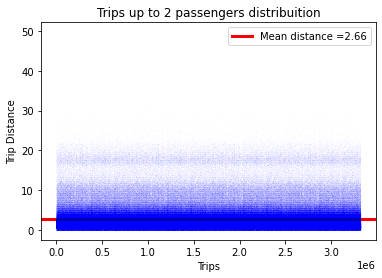

In [39]:
y1=trips_upto2p['trip_distance']
x1=pd.Series(np.linspace(0,len(y1),len(y1)))
y2=mean_trips


fig=plt.figure()
ax=fig.add_subplot(111)
ax.set(title='Trips up to 2 passengers distribuition')
plt.xlabel('Trips')
plt.ylabel('Trip Distance')
plt.axhline(y=y2,color='r',linewidth=3,label='Mean distance ='+str(round(mean_trips,2)))
plt.legend()
ax.plot(x1,y1,'bo', markersize=0.005)
plt.show();

### RESOLVENDO QUESTAO 2
**2. Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado**    

In [41]:
from sqlite3 import connect
conn = connect(':memory:')
trips_all.to_sql('data_all', conn) 
vendors_amounts=pd.read_sql('SELECT SUM(total_amount), vendor_id FROM data_all GROUP BY vendor_id', conn)

conn.close()

Best=vendors_amounts.sort_values('SUM(total_amount)',ascending=False).nlargest(3, 'SUM(total_amount)')

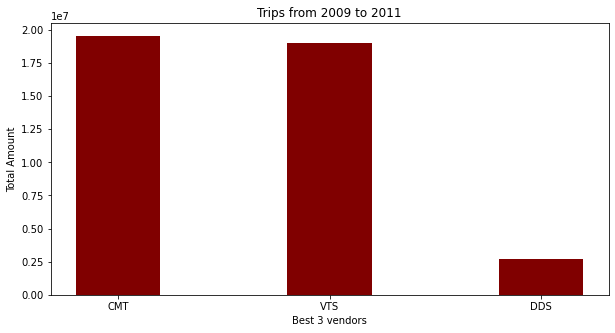

In [42]:
fig = plt.figure(figsize = (10, 5))
plt.bar(Best['vendor_id'], Best['SUM(total_amount)'], color ='maroon',
        width = 0.4) 
plt.xlabel("Best 3 vendors")
plt.ylabel("Total Amount")
plt.title("Trips from 2009 to 2011")
plt.show()

### RESOLVENDO QUESTAO 3:
    
**3. Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro**
 

Lendo o arquivo com as informações dos tipos pagamentos

In [44]:
url = 'https://s3.amazonaws.com/data-sprints-eng-test/data-payment_lookup-csv.csv'

In [45]:
trip_pay_meth=pd.read_csv(url)

In [46]:
trip_pay_meth=trip_pay_meth.loc[trip_pay_meth['B']=='Cash',['A']]
trip_pay_meth=pd.DataFrame(trip_pay_meth['A'])
trip_pay_meth=trip_pay_meth['A'].astype(str).values.tolist()

Lendo cada ano separadamente para plotar as informações por ano

In [47]:
trip2009_cash=trip2009.loc[trip2009['payment_type'].isin(trip_pay_meth),['dropoff_datetime']]
trip2010_cash=trip2010.loc[trip2010['payment_type'].isin(trip_pay_meth),['dropoff_datetime']]
trip2011_cash=trip2011.loc[trip2011['payment_type'].isin(trip_pay_meth),['dropoff_datetime']]
trip2012_cash=trip2012.loc[trip2012['payment_type'].isin(trip_pay_meth),['dropoff_datetime']]

trip2009_cash['dropoff_datetime'] = trip2009_cash['dropoff_datetime'].astype("datetime64")
trip2010_cash['dropoff_datetime'] = trip2010_cash['dropoff_datetime'].astype("datetime64")
trip2011_cash['dropoff_datetime'] = trip2011_cash['dropoff_datetime'].astype("datetime64")
trip2012_cash['dropoff_datetime'] = trip2012_cash['dropoff_datetime'].astype("datetime64")

Contabilizando quantas viagens foram feitas a cada mês

In [48]:
trip2009_cash=trip2009_cash.groupby(trip2009_cash['dropoff_datetime'].dt.month).count()
trip2010_cash=trip2010_cash.groupby(trip2010_cash['dropoff_datetime'].dt.month).count()
trip2011_cash=trip2011_cash.groupby(trip2011_cash['dropoff_datetime'].dt.month).count()
trip2012_cash=trip2012_cash.groupby(trip2012_cash['dropoff_datetime'].dt.month).count()

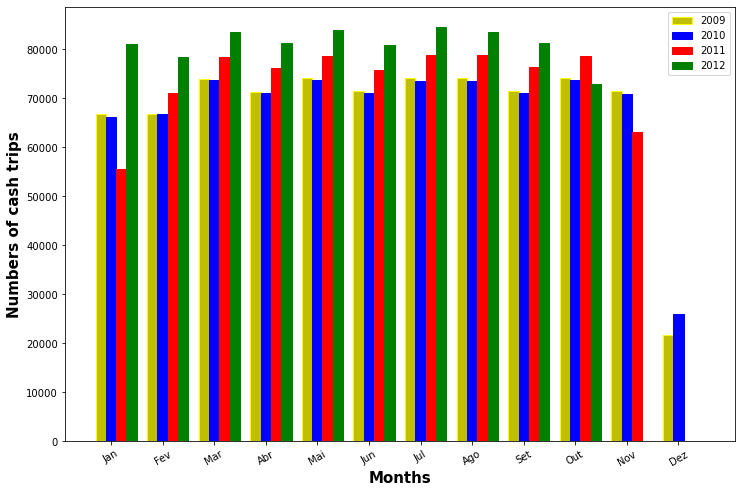

In [51]:
#Largura das barras
barWidth = 0.20
fig = plt.subplots(figsize =(12, 8)) 

#Posição das barras
br2009 = np.arange(len(trip2009_cash))
br2010 = [x + barWidth for x in br2009]
br2011 = [x + barWidth for x in br2010]
br2012 = [x + barWidth for x in br2011]

y1=trip2009_cash['dropoff_datetime']
y2=trip2010_cash['dropoff_datetime']
y3=trip2011_cash['dropoff_datetime']
y4=trip2012_cash['dropoff_datetime']

#Garantindo as mesmas dimensões entre os dataframes
y1=np.pad(y1, ((0,12-len(y1))), mode='constant')
y2=np.pad(y2, ((0,12-len(y2))), mode='constant')
y3=np.pad(y3, ((0,12-len(y3))), mode='constant')
y4=np.pad(y4, ((0,12-len(y4))), mode='constant')


#Plotando
plt.bar(br2009, y1, color ='y', width = barWidth,
        edgecolor ='yellow', label ='2009')
plt.bar(br2010, y2, color ='b', width = barWidth,
        edgecolor ='blue', label ='2010')
plt.bar(br2011, y3, color ='r', width = barWidth,
        edgecolor ='red', label ='2011')
plt.bar(br2012, y4, color ='g', width = barWidth,
        edgecolor ='green', label ='2012')
 
#Colocando legendas
plt.xlabel('Months', fontweight ='bold', fontsize = 15)
plt.ylabel('Numbers of cash trips', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(trip2009_cash))],
        ['Jan', 'Fev', 'Mar', 'Abr', 'Mai','Jun','Jul','Ago','Set','Out','Nov','Dez'],rotation=30)
 
plt.legend()
plt.show();

### RESOLVENDO QUESTAO 4
**4. Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.**

In [52]:
trip_2012=trip2012[['dropoff_datetime','tip_amount']]
trip_2012['dropoff_datetime'] = trip_2012['dropoff_datetime'].astype("datetime64")

<ipython-input-52-927c49148500>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_2012['dropoff_datetime'] = trip_2012['dropoff_datetime'].astype("datetime64")


Estabelecendo a data de inicio e fim do último trimestre

In [54]:
start_date='09-01-2012'
end_date='12-31-2012'
start_date = datetime.strptime(start_date,'%m-%d-%Y')
end_date = datetime.strptime(end_date,'%m-%d-%Y')

pd.options.mode.chained_assignment = None
trip_3rdQ2012=trip_2012.loc[(trip_2012['dropoff_datetime']>=start_date) & (trip_2012['dropoff_datetime']<=end_date)]
trip_3rdQ2012=trip_3rdQ2012.dropna()
trip_3rdQ2012= trip_3rdQ2012.sort_values('dropoff_datetime', ascending=True)

Somando valores por dia

In [55]:
tip_per_day=trip_3rdQ2012.groupby(trip_3rdQ2012['dropoff_datetime'].dt.date).sum()

Criando o eixo do tempo

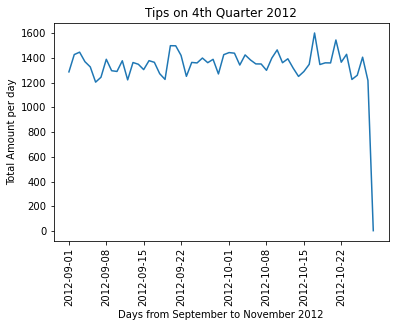

In [56]:
date_days = pd.DataFrame(tip_per_day.index)

plt.xlabel("Days from September to November 2012")
plt.ylabel("Total Amount per day")
plt.title("Tips on 4th Quarter 2012")
plt.plot(date_days,tip_per_day)
plt.xticks(rotation='vertical');